In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision


In [2]:
# Transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the data to [-1, 1]
])

# Load the dataset
batch_size = 100
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


In [3]:
# Generator
class Generator(nn.Module):
    def __init__(self, input_size=100, output_size=784):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),

            nn.Linear(256, 256),
            nn.ReLU(),

            nn.Linear(256, 256),
            nn.ReLU(),

            nn.Linear(256, output_size),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size=784):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
latent_size = 64
output_size = 784
num_epochs = 50
d_lr = 0.0002
g_lr = 0.0005
input_size=64

# Initialize models
generator = Generator(input_size=latent_size, output_size=output_size).to(device)
discriminator = Discriminator(input_size=output_size).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer_d = optim.Adam(discriminator.parameters(), lr=d_lr)
optimizer_g = optim.Adam(generator.parameters(), lr=g_lr)


Epoch [1/10] , Loss D: 0.6887, Loss G: 2.5731
Epoch [2/10] , Loss D: 1.0301, Loss G: 1.9023
Epoch [3/10] , Loss D: 1.4356, Loss G: 0.8954
Epoch [4/10] , Loss D: 1.4011, Loss G: 0.4966
Epoch [5/10] , Loss D: 1.2552, Loss G: 0.6412


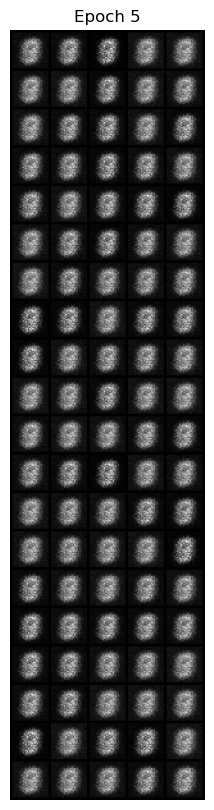

Epoch [6/10] , Loss D: 0.5725, Loss G: 1.4893
Epoch [7/10] , Loss D: 0.6950, Loss G: 2.2571
Epoch [8/10] , Loss D: 0.8281, Loss G: 1.2112
Epoch [9/10] , Loss D: 1.3922, Loss G: 1.5250
Epoch [10/10] , Loss D: 1.8136, Loss G: 1.0040


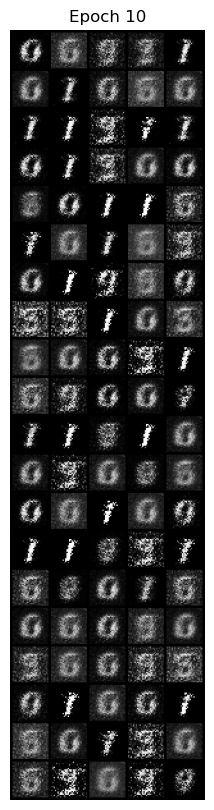

In [5]:
# Labels
real_label = 1
fake_label = 0

# Lists to keep track of progress
losses_g = []
losses_d = []
epochs_list = []

# Training loop
for epoch in range(1, num_epochs+1):
    for i, (images, _) in enumerate(train_loader):
        # Flatten MNIST images into a vector
        images = images.view(-1, 784).to(device)

        # Create labels
        real_labels = torch.full((images.size(0),), real_label, dtype=torch.float, device=device)
        fake_labels = torch.full((images.size(0),), fake_label, dtype=torch.float, device=device)

        # ============================================
        # Train the Discriminator
        # ============================================
        discriminator.zero_grad()

        # Train on real images
        outputs = discriminator(images)
        loss_real = criterion(outputs.squeeze(), real_labels)
        loss_real.backward()

        # Train on fake images
        noise = torch.randn(images.size(0), latent_size, device=device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        loss_fake = criterion(outputs.squeeze(), fake_labels)
        loss_fake.backward()

        # Update discriminator
        optimizer_d.step()

        loss_d = loss_real + loss_fake

        # ============================================
        # Train the Generator
        # ============================================
        generator.zero_grad()

        # Generate fake images and compute loss
        outputs = discriminator(fake_images)
        loss_g = criterion(outputs.squeeze(), real_labels)  # Generator tries to make discriminator output labels as real
        loss_g.backward()

        # Update generator
        optimizer_g.step()

        # Print training stats
    print(f'Epoch [{epoch}/{num_epochs}] , Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')

    # Save losses for plotting
    losses_g.append(loss_g.item())
    losses_d.append(loss_d.item())
    epochs_list.append(epoch)
    
    # Visualize progress every 5 epochs
    if epoch % 5 == 0 or epoch == epoch - 1:
        with torch.no_grad():
            fake_images = generator(noise).view(-1, 1, 28, 28).cpu()
            grid = torchvision.utils.make_grid(fake_images, nrow=5, normalize=True)
            plt.figure(figsize=(10, 10))
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.title(f"Epoch {epoch}")
            plt.axis("off")
            plt.show()


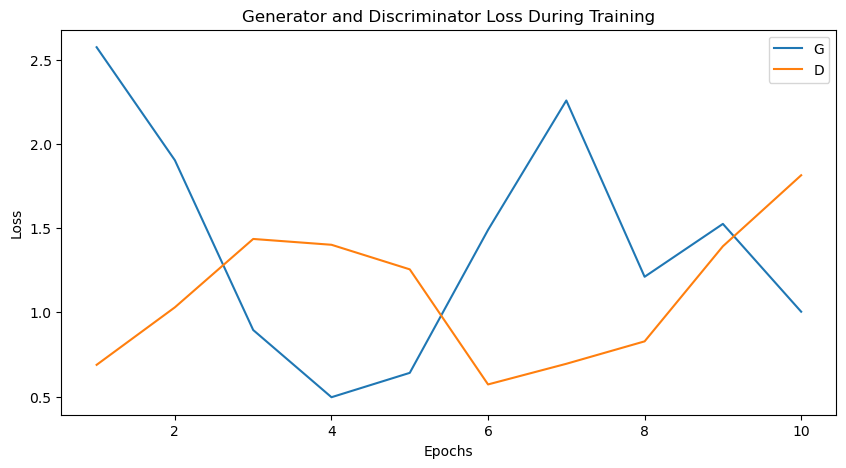

In [6]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(epochs_list, losses_g, label="G")
plt.plot(epochs_list, losses_d, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


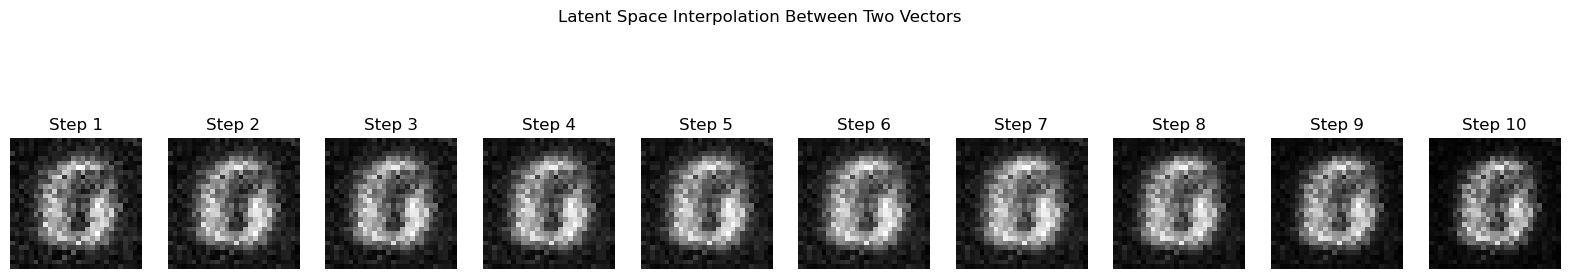

The transitions between the images appear smooth, with gradual changes that reflect the latent space interpolation. The generated images transform realistically, demonstrating how the GAN has learned to represent the distribution of the MNIST digits.


In [9]:
# Latent Space Interpolation
n_steps = 10
z1 = torch.randn(1, input_size).to(device)
z2 = torch.randn(1, input_size).to(device)

interpolated_images = []
with torch.no_grad():
    for alpha in np.linspace(0, 1, n_steps):
        z_interp = (1 - alpha) * z1 + alpha * z2
        generated_image = generator(z_interp).view(1, 1, 28, 28).cpu()
        interpolated_images.append(generated_image)

# Visualize Interpolated Images
plt.figure(figsize=(20, 4))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, n_steps, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(f"Step {i+1}")
plt.suptitle("Latent Space Interpolation Between Two Vectors")
plt.show()

# Comment on Smoothness
print("The transitions between the images appear smooth, with gradual changes that reflect the latent space interpolation."
      " The generated images transform realistically, demonstrating how the GAN has learned to represent the distribution of the MNIST digits.")